In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot

In [2]:
dir(nengo)

['AdaptiveLIF',
 'AdaptiveLIFRate',
 'Alpha',
 'BCM',
 'Config',
 'Connection',
 'Conv',
 'ConvTranspose',
 'Convolution',
 'ConvolutionTranspose',
 'Default',
 'Dense',
 'Direct',
 'Ensemble',
 'Izhikevich',
 'LIF',
 'LIFRate',
 'LinearFilter',
 'Lowpass',
 'Network',
 'Node',
 'Oja',
 'PES',
 'PoissonSpiking',
 'Probe',
 'Process',
 'RC_DEFAULTS',
 'RLS',
 'RectifiedLinear',
 'RegularSpiking',
 'Sigmoid',
 'Simulator',
 'Sparse',
 'SpikingRectifiedLinear',
 'StochasticSpiking',
 'Tanh',
 'Triangle',
 'Voja',
 '__builtins__',
 '__cached__',
 '__copyright__',
 '__doc__',
 '__file__',
 '__license__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_vendor',
 'base',
 'builder',
 'cache',
 'config',
 'connection',
 'dists',
 'ensemble',
 'exceptions',
 'learning_rules',
 'logger',
 'logging',
 'network',
 'networks',
 'neurons',
 'node',
 'params',
 'presets',
 'probe',
 'processes',
 'rc',
 'simulator',
 'solvers',
 'spa',
 'synapses',
 'sys',
 't

In [3]:
# Step 1: Create the Neuron
from nengo.dists import Uniform

model = nengo.Network(label="A Single Neuron")
with model:
    neuron = nengo.Ensemble(
        1,
        dimensions=1,  # Represent a scalar
        # Set intercept to 0.5
        intercepts=Uniform(-0.5, -0.5),
        # Set the maximum firing rate of the neuron to 100hz
        max_rates=Uniform(100, 100),
        # Set the neuron's firing rate to increase for positive input
        encoders=[[1]],
    )

In [4]:
# Step 2: Provide Input to the Model
with model:
    cos = nengo.Node(lambda t: np.cos(8 * t))

In [5]:
# Step 3: Connect the Network Elements
with model:
    # Connect the input signal to the neuron
    nengo.Connection(cos, neuron)

In [6]:
# Step 4: Add Probes
with model:
    # The original input
    cos_probe = nengo.Probe(cos)
    # The raw spikes from the neuron
    spikes = nengo.Probe(neuron.neurons)
    # Subthreshold soma voltage of the neuron
    voltage = nengo.Probe(neuron.neurons, "voltage")
    # Spikes filtered by a 10ms post-synaptic filter
    filtered = nengo.Probe(neuron, synapse=0.01)

In [7]:
# Step 5: Run the Model
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(2)  # Run it for 2 second

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0, 0.5, 'Amplitude')

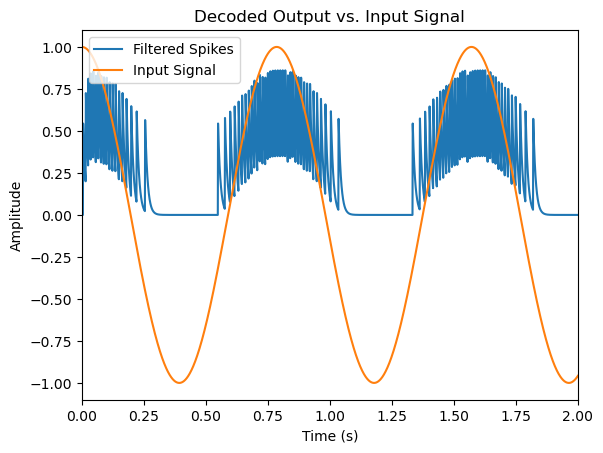

In [8]:
# Step 6: Plot the Results
# Plot the decoded output of the ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[filtered], label="Filtered Spikes")
plt.plot(sim.trange(), sim.data[cos_probe], label="Input Signal")
plt.xlim(0, 2)
plt.legend()
plt.title("Decoded Output vs. Input Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


Text(0.5, 1.0, 'Spiking Output of the Ensemble')

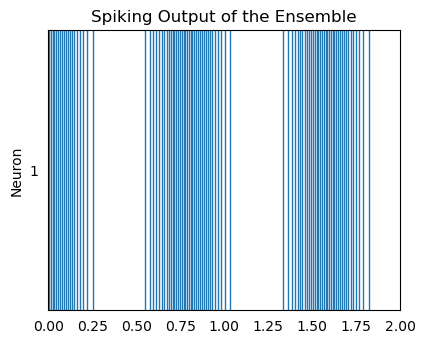

In [9]:
# Plot the spiking output of the ensemble
plt.figure(figsize=(10, 8))
plt.subplot(221)
rasterplot(sim.trange(), sim.data[spikes])
plt.ylabel("Neuron")
plt.xlim(0, 2)
plt.title("Spiking Output of the Ensemble")



Text(0, 0.5, 'Voltage (V)')

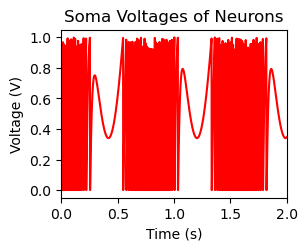

In [10]:
# Plot the soma voltages of the neurons
plt.subplot(222)
plt.plot(sim.trange(), sim.data[voltage][:, 0], "r")
plt.xlim(0, 2)
plt.title("Soma Voltages of Neurons")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

In [ ]:
#### Basal Ganglia, action selector for whatever has the best salience (Stewart, 2010)

In [12]:
model = nengo.Network(label="Basal Ganglia")
with model:
    basal_ganglia = nengo.networks.BasalGanglia(dimensions=3)  ## the three dimensions are eat, sleep, play (not important though)


class ActionIterator:
    def __init__(self, dimensions):   #### self refers to the instance itself
        self.actions = np.ones(dimensions) * 0.1  ### creates a one dimensional nmpy array 

    def step(self, t):
        # one action at time dominates
        dominate = int(t % 3) ## creates cyclic pattern with values 0, 1 and 2 (these are the only possibly remainders when dividing by 3)
        self.actions[:] = 0.1 ## reset step
        self.actions[dominate] = 0.8  ## set the dominate index to 0.8 (use the dominate variable as an index)
        return self.actions  ### return the updated array


action_iterator = ActionIterator(dimensions=3) ### object with one-dimensional array with three elements

with model:
    actions = nengo.Node(action_iterator.step, label="actions")

In [13]:
with model:
    nengo.Connection(actions, basal_ganglia.input, synapse=None)
    selected_action = nengo.Probe(basal_ganglia.output, synapse=0.01)
    input_actions = nengo.Probe(actions, synapse=0.01)

In [14]:
with nengo.Simulator(model) as sim:
    sim.run(6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

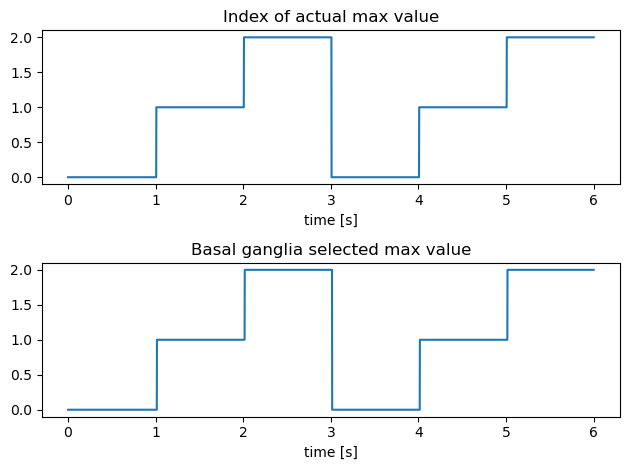

In [15]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[input_actions].argmax(axis=1))
plt.ylim(-0.1, 2.1)
plt.xlabel("time [s]")
plt.title("Index of actual max value")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[selected_action].argmax(axis=1))
plt.ylim(-0.1, 2.1)
plt.xlabel("time [s]")
plt.title("Basal ganglia selected max value")
plt.tight_layout()